In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import math
from datetime import date
import datetime
from functools import reduce
import warnings
import random
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from collections import Counter
import squarify # pip install squarify (algorithm for treemap)
import matplotlib.pyplot as plt; plt.rcdefaults()
warnings.filterwarnings("ignore")

In [5]:
personal_data = pd.read_csv('./data/personal_train.csv')
personal_data = personal_data.drop(['Unnamed: 0'], axis=1)
other_data = pd.read_csv('./data/other_train.csv')
other_data = other_data.drop(['Unnamed: 0'], axis=1)

merged = pd.DataFrame()

class MergeTransformer(TransformerMixin):
    def __init__(self,df1,df2,cols):
        self.df1 = df1
        self.df2 = df2
        self.cols = cols
    
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df = pd.merge(self.df1,self.df2,on=self.cols)
        return df

class DeduplicationTransformer(TransformerMixin):
    def __init__(self,cols,groupBy):
        self.cols = cols
        self.groupBy = groupBy
    
    def _checkNaN(self,arr):
        for item in arr:
            if((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item)):
                return False
        return True
    def _checkQuestionMark(self,arr):
        for item in arr:
            if(item is not '?'):
                return False
        return True
    def _nanOrQuestionMark(self,arr):
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                return False
        return True
    
    def _filter_nan_question_mark(self,arr):
        result = []
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                result.append(item)
        return result 
    
    def _getUniqueRow(self,duplicates,startIndex,endIndex):
        row_dict = {}

        for column in duplicates.columns: 
            temp = []
            for index in range(startIndex,endIndex):
                temp.append(duplicates.iloc[index][column])
         
            if(self._checkNaN(temp)):
                row_dict[column] = np.nan
            elif(self._checkQuestionMark(temp)):
                row_dict[column] = '?'
            elif(self._nanOrQuestionMark(temp)):
                row_dict[column] = np.nan
            else:
                temp = self._filter_nan_question_mark(temp)
                value = randint(0,len(temp)-1)
                row_dict[column] = temp[value]
        return row_dict

    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        duplicated = df.duplicated(subset=self.cols,keep=False)
        duplicates = pd.DataFrame(columns=df.columns)
        indexes_to_drop = []
        df_without_duplicates = pd.DataFrame(columns=df.columns)
        for index, row in df.iterrows():
            if(duplicated[index]):
                duplicates = duplicates.append(df.iloc[index],ignore_index=True)
                indexes_to_drop.append(index)

        duplicates.sort_values(self.cols)
        df_without_duplicates = df
        for index in indexes_to_drop:
            df_without_duplicates = df_without_duplicates.drop(df.index[index])

        df = df_without_duplicates
        count = 0
        lastDuplicate = duplicates.iloc[0][self.groupBy]
        columns = duplicates.columns.values
        for index,row in duplicates.iterrows():
            entry = duplicates.iloc[index]
            name = entry[self.groupBy]
            if(name == lastDuplicate):
                count += 1
            else:
                df = df.append(self._getUniqueRow(duplicates,index-count,index),ignore_index=True)
                lastDuplicate = name
                count = 1
        
            if(len(duplicates) - 1 == index):
                df = df.append(self._getUniqueRow(duplicates,index-count+1,index + 1),ignore_index=True)
        
        return df

class ToNaNTransformer(TransformerMixin):
    def __init__(self,signs):
        self.signs = signs
    
    def _checkSign(self,x):
        for sign in self.signs:
            if sign == str(x).strip(" "):
                return True
        return False
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in df.columns:
            df[column] = df[column].map(lambda x: np.nan if self._checkSign(x) else x)
        return df

class ObjectValuesTransformer(TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index, row in df.iterrows():
            for column in self.cols:
                if(str(row[column]) != 'nan'):
                    newRow = eval(str(row[column]))
                    for key, value in newRow.items():
                        df.loc[index,key] = value
        return df
        
class MeanTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.col_means = {}
        
    def fit(self,df, y=None):
        
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.col_means[column] = math.floor(np.nanmean(df[column].tolist()))
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.col_means[column] if str(x).lower() == 'nan' else float(x))
        return df

class FormatDateTransformer(TransformerMixin):
    def __init__(self,column):
        self.column = column
    def _format_date(self,string):
        for fmt in ["%Y/%m/%d", "%Y%m%d", "%y-%m-%d", "%Y-%m-%d", "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H %M %S", "%d/%m/%Y"]:
            try:
                return datetime.datetime.strptime(string, fmt).date()
            except ValueError:
                continue
        raise ValueError(string)
        
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df[self.column] = df[self.column].map(lambda x: self._format_date(x) if type(x) is str else x)
        return df
    
class MeanDateTransformer(TransformerMixin):
    def __init__(self,age_column,date_column):
        self.age_column = age_column
        self.date_column = date_column
        self.mean_age = 0;
        self.mean_date = 0;
        
    def fit(self,df,y=None):
        self.mean_age = np.nanmean(df[self.age_column].tolist())
        self.mean_date = datetime.datetime(math.floor(datetime.datetime.now().year - self.mean_age), datetime.datetime.now().month, datetime.datetime.now().day,
                           datetime.datetime.now().hour, datetime.datetime.now().minute).date()
        return self
    def transform(self,df,y=None):
        df[self.date_column] = df[self.date_column].map(lambda x: self.mean_date if str(x) == 'nan' else x)
        i = 0
        for date in df[self.date_column]:
            if(date > datetime.datetime.now().date()):
                modifiedDate = datetime.datetime(datetime.datetime.now().year-int(df[self.age_column][i]), date.month, date.day).date()
                df[self.date_column][i] = modifiedDate 
            i += 1
        return df
    
class TrueFalseTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def _mapTrueFalse(self,x):
        if("t" in str(x).lower()):
            return "t"
        elif("f" in str(x).lower()):
            return "f"
        else:
            return np.nan
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self._mapTrueFalse(x))
        return df
class MedianTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_median = {}
        
    def fit(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.cols_median[column] = np.nanmedian(df[column].tolist())
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.cols_median[column] if str(x).lower() == 'nan' else x)
        return df
    
class CategoricalTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_value_to_fill = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.cols_value_to_fill[column] = pd.Series(np.random.choice(self._getUniqueValues(df[column]),p=self._getRatio(df[column]),size=len(df[column])))
        return self
    
    def _getUniqueValues(self,arr):
        return arr.value_counts(normalize=True, dropna=True).index

    def _getRatio(self,arr):
        return arr.value_counts(normalize=True, dropna=True).values
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].fillna(self.cols_value_to_fill[column])
        return df

class ReplacerTransformer(TransformerMixin):
    def __init__(self,replace_info_arr):
        self.all_info = []
        for replace_info in replace_info_arr:
            self.all_info.append(replace_info)
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for info in self.all_info:
            df[info["column"]] = df[info["column"]].map(lambda x: x.lower().replace(info["current"],info["new"]))
        return df
            
class KnearestTransformer(TransformerMixin):
    def __init__(self,columns,k=3):
        self.columns = columns
        self.k_num = k
    
    def _kNearest(self,df,column,k=3):
        kNearest = []
        i = 0
        for item in df[column]:
            if(str(item) == 'nan'):
                kNearest = []
                for index in range(2*k+1):
                    if(i+k-index < len(df) and i+k-index > -1 and i+k-index != i and str(df[column][i+k-index]) != 'nan'):
                        kNearest.append(df[column][i+k-index])
                nearestAvg = reduce(lambda x, y: x + y, kNearest) / len(kNearest)
                df[column][i] = math.floor(nearestAvg)
            i += 1
        return df
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
               df = self._kNearest(df,column,self.k_num)
        return df
    
class OutlayersRemovalForAgeAndDateTransformer(TransformerMixin):
    
    def __init__(self,age_column,date_column,value):
        self.age_column = age_column
        self.date_column = date_column
        self.value = value
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            if(df[self.age_column][index] > self.value):
                df[self.age_column][index] = self.value
                df[self.date_column] = datetime.datetime(math.floor(datetime.datetime.now().year - self.value), df[self.date_column][index].month, df[self.date_column][index].day).date()
                
        return df
    
class FormatToFloatTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
        return df
    
class OutlayersRemoval(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.outlayer_95 = {}
        self.outlayer_5 = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.outlayer_95[column] = np.nanpercentile(df[column],95)
            self.outlayer_5[column] = np.nanpercentile(df[column],5)
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            for column in self.columns:
                if df[column][index] > self.outlayer_95[column]:
                    df[column][index] = self.outlayer_95[column]
                elif df[column][index] < self.outlayer_5[column]:
                    df[column][index] = self.outlayer_5[column]
        return df
            
        
        
true_false_columns = ["sick","T3 measured","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TBG measured","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "T4U measured", "tumor",
                    "goitre","hypopituitary","on antithyroid medication"]

categorical_columns = ["sick","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "tumor",
                     "goitre","hypopituitary","on antithyroid medication","sex","workclass","native-country","occupation","T3 measured","T4U measured"]

replace_info = [
    {
        "column":"education",
        "current":"_",
        "new":"-"
    },
    {
        "column":"class",
        "current": ".|",
        "new":"|"
    }
]


pip = Pipeline([
    ('merge',MergeTransformer(personal_data,other_data,["name","address"])),
    ('objectvalues',ObjectValuesTransformer(["medical_info"])),
    ('deduplicate',DeduplicationTransformer(["name","address"],"name")),
    ('nan',ToNaNTransformer(["?","nan"])),
    ('format-date',FormatDateTransformer("date_of_birth")),
    ('format-to-floats',FormatToFloatTransformer(["age","T4U","capital-loss","TSH","FTI","T3","education-num","TT4"])),
    ('date-outlayers',OutlayersRemovalForAgeAndDateTransformer("age","date_of_birth",110)),
    ('outlayers',OutlayersRemoval(["age","T4U","capital-loss","TSH","FTI","T3","education-num","TT4"])),
    ('mean',MeanTransformer(["age","T4U","capital-loss","TSH","FTI"])),
    ('median',MedianTransformer(["T3","education-num"])),
    ('knearest',KnearestTransformer(["TT4"])),
    ('date',MeanDateTransformer("age","date_of_birth")),
    ('true-false-mapping',TrueFalseTransformer(true_false_columns)),
    ('categorical',CategoricalTransformer(categorical_columns)),
    ('replacer',ReplacerTransformer(replace_info))
])
model = pip.fit(merged)
merged = pip.transform(merged)



In [9]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 46 columns):
name                         2237 non-null object
address                      2237 non-null object
age                          2237 non-null float64
sex                          2237 non-null object
date_of_birth                2237 non-null object
query hyperthyroid           2237 non-null object
FTI measured                 2237 non-null object
education                    2237 non-null object
lithium                      2237 non-null object
TT4                          2237 non-null float64
T4U                          2237 non-null float64
capital-loss                 2237 non-null float64
capital-gain                 2237 non-null float64
tumor                        2237 non-null object
TSH                          2237 non-null float64
T3                           2237 non-null float64
fnlwgt                       2237 non-null float64
hours-per-week               2237 n

In [20]:
def ShowPieChart(data,when):
    ages = '0-110', 'else'
    hist = [0,0]
    y_pos = np.arange(len(ages))
    for item, frame in data.iteritems():
        if math.isnan(frame):
            hist[1] = hist[1] + 1
        if frame > 110:
            hist[1] = hist[1] + 1
        if frame > 0 and frame < 110:
            hist[0] = hist[0] + 1
        if frame < 0:
            hist[1] = hist[1] + 1    

    labels = ['0-110','else']
    sizes = [hist[0], hist[1]]
    colors = ['lightskyblue', 'lightcoral']

    plt.title(when)
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=120)
    plt.legend(labels, loc="best")
    plt.axis('equal')
    plt.figure(0)
    plt.tight_layout()

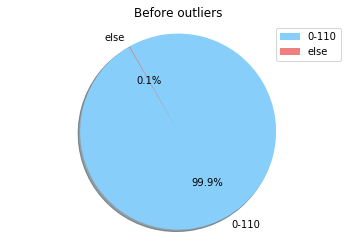

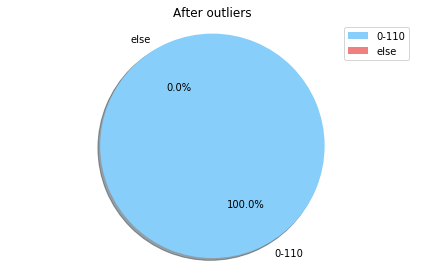

In [22]:
ShowPieChart(personal_data["age"], "Before outliers")

ShowPieChart(merged["age"],"After outliers")

plt.show()




#Ako môžeme vidieť, tak pred čistením dát máme 99,9% úspešných vekov, no z pomedzi všetkých záznamov sa našli aj také, ktoré
#obsahovali NaN, zápornú hodnotu, alebo väčší vek ako 110

In [14]:
def showBoxPlot(arr, name, row, column):    
    plt.subplot2grid(fig_dims, (row, column))
    plt.title('%s - distribúcia hodnôt' %name)
    objects = ('Before', 'After')
    plt.boxplot(arr)
    y_pos = np.arange(len(arr))
    plt.xticks(y_pos+1, objects)
    
def showBoxPlotForColumns(arrayOfColumns):
    rows = 0
    columns = 0
    for column in arrayOfColumns:
        beforeOutliers = other_data[column]
        beforeOutliers = beforeOutliers[~np.isnan(other_data[column])]
        
        data = [beforeOutliers,merged[column]]
        showBoxPlot(data, column, rows, columns)
        columns += 1
        if(columns > 2):
            rows += 1
            columns = 0

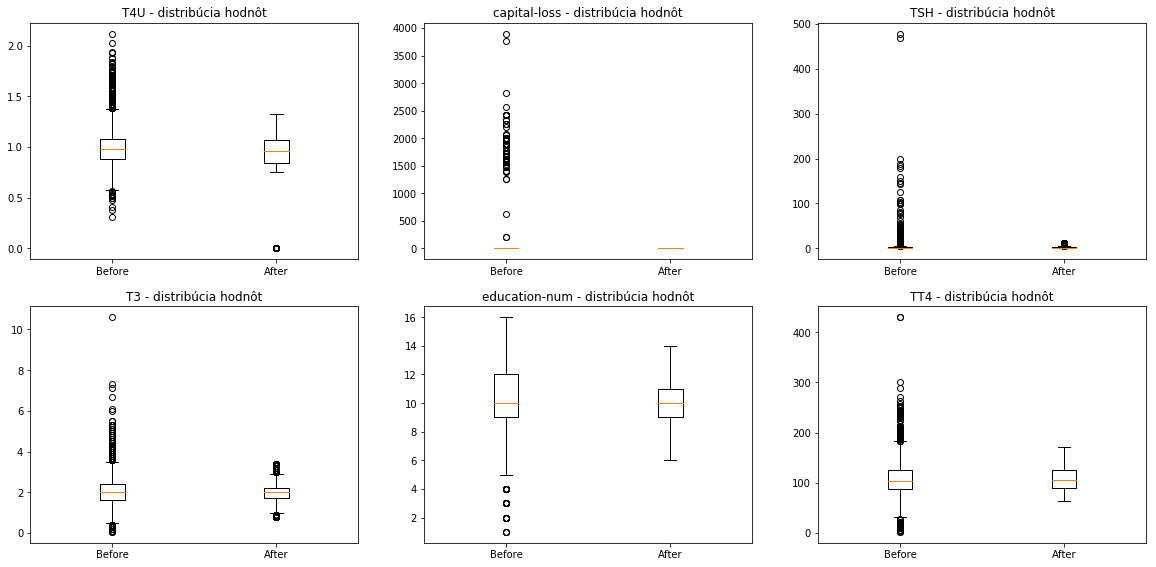

In [15]:
fizsize_with_subplots = (20, 20)
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (4,3)
numColumns = ["T4U","capital-loss","TSH","T3","education-num","TT4"]



#------------------------------------------------
#  FTI nejde zobrazit kvoli ,,?:""
#------------------------------------------------



showBoxPlotForColumns(numColumns)
plt.show()


PRED A PO FALSE HODNOTY, TREBA DOPLNIT AJ SICK, GOITRE A OSTATNE!!!!!!!
----------------------------


In [16]:
def TrueFalseGraph(data,index, description):
    data.value_counts().plot(ax=axs[index], kind='bar',title = description)

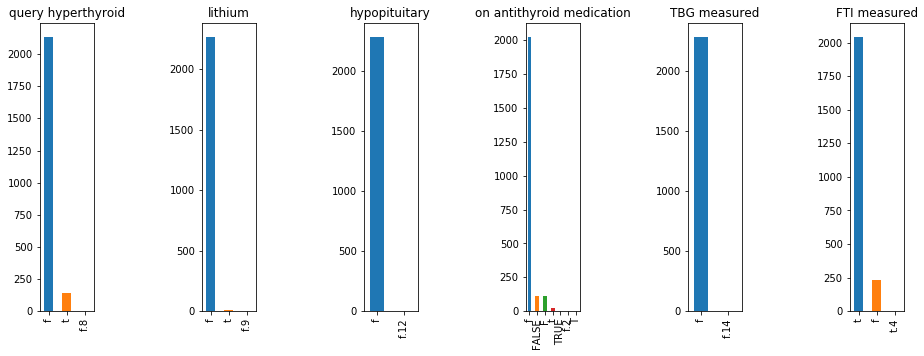

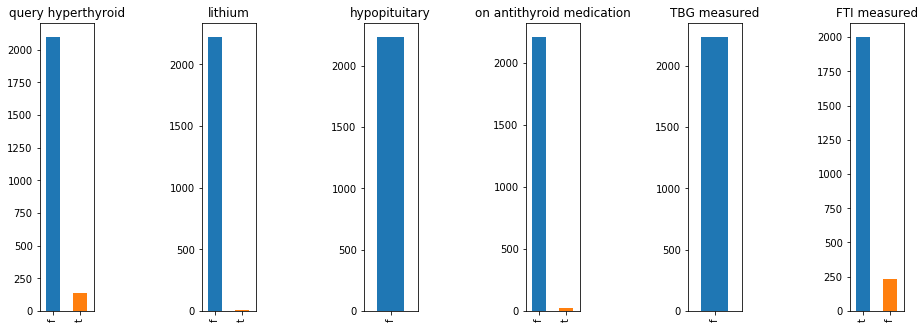

In [17]:
x =  [other_data, merged]

for ds in x:

    fig, axs = plt.subplots(1,6)
    arr = [ds['query hyperthyroid'],ds['lithium'], ds['hypopituitary'],ds['on antithyroid medication'],ds['TBG measured'],ds['FTI measured'] ]

    i = 0
    for col in arr:
        TrueFalseGraph(col,i,col.name)
        i = i + 1

    plt.subplots_adjust(left=4, bottom=3, right=6, top=4, wspace=2, hspace=1)
    plt.show()


In [38]:
def ShowHistogram(column, title,randColor ):
    x = [other_data,merged]

    iter = 0
    for ds in x:

        labels = set(ds[column])
        mynewlist = list(labels)

        mynewlist
        hist = []
        triangle = []
        for h in mynewlist:
            hist.append(0)
            triangle.append(0.10)

        i = 0    
        for educationType in mynewlist:
            for row in ds[column]:
                if row == educationType:
                    hist[i] = 1 + hist[i]

            i = i + 1    
        #newhist = mynewlist.map(lambda x: "unnamed" if str(x).lower() == 'nan' else x)
        resultsList = ["unnamed" if str(x).lower() == 'nan' else x for x in mynewlist]
        resultsHist = [0 if x == 0 else x for x in hist]
        y_pos = np.arange(len(resultsHist))
        plt.barh(y_pos, resultsHist, align='center',color=randColor, alpha=0.5)
        plt.yticks(y_pos, resultsList)
        if iter == 0:
            plt.title(title + " before")
        else:
            plt.title(title + " after")      
        plt.plot(figsize=(20,10))
        plt.show() 
        iter = iter + 1

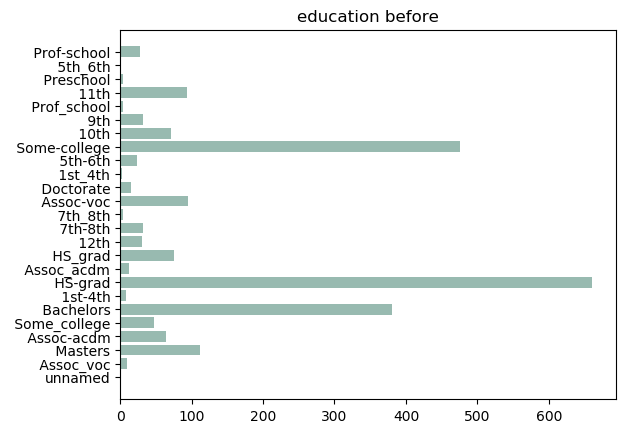

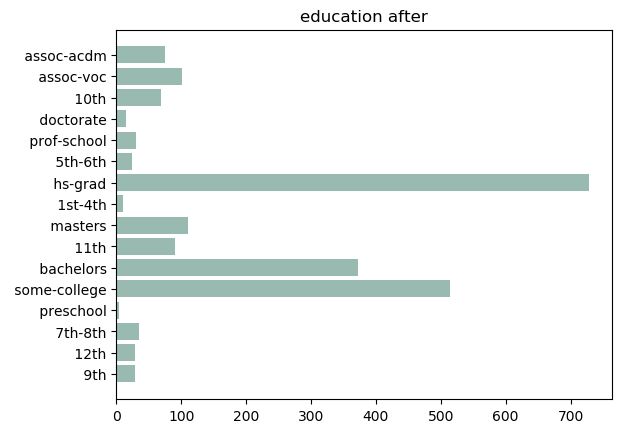

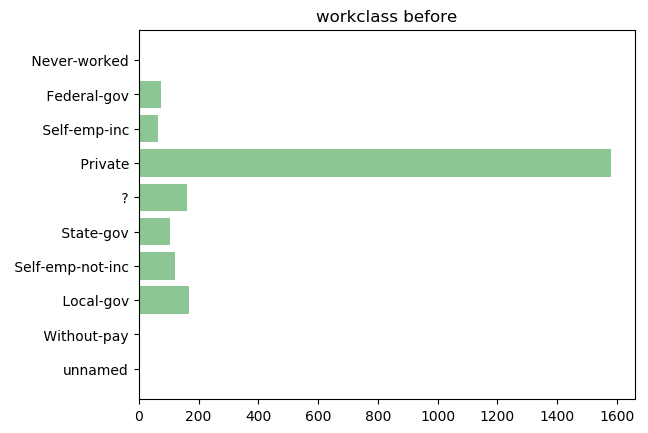

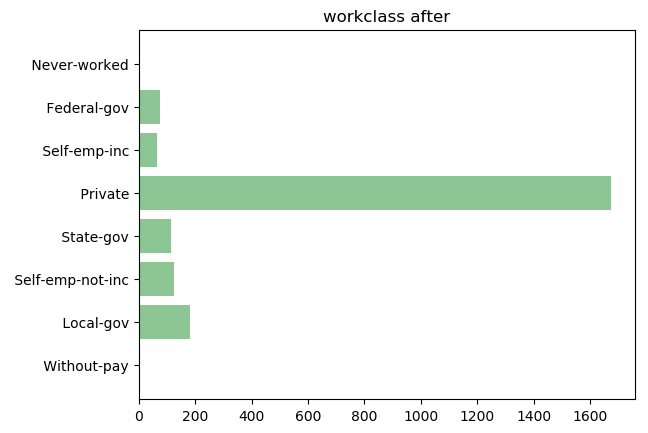

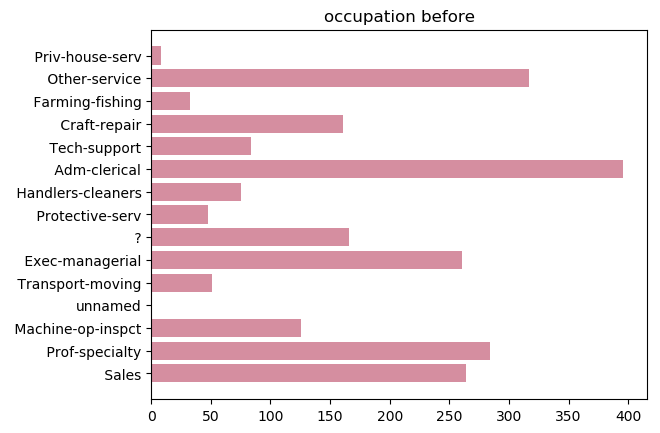

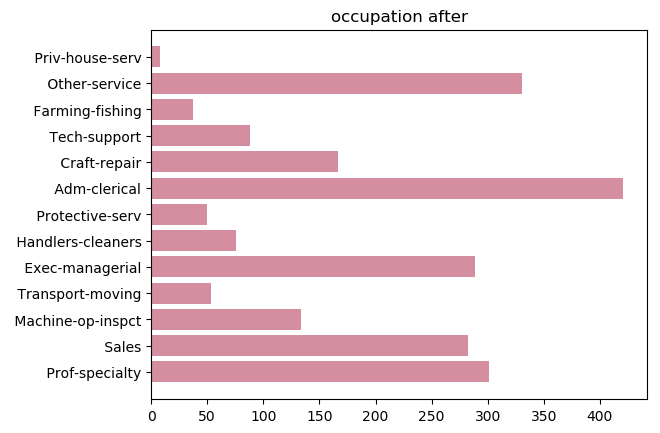

In [39]:
x = "education","workclass","occupation"



#----------------------------
# TREBA TAM AJ INE ??
#----------------------------

for col in x:
    randColor = (random.uniform(0, 0.7),random.uniform(0, 0.7),random.uniform(0, 0.7),0.5)
    if randColor[0] == 1 and randColor[1] == 1 and randColor[2] == 1:
        randColor = (1,0,0,0.5)
    ShowHistogram(col,col,randColor)
